# Shotgun metagenomic single end library

In [33]:
from os.path import join as pjoin
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import skbio
import skbio.diversity
import seaborn as sns
import random

In [34]:
plt.style.use('seaborn')
%matplotlib inline

### Dataset

CONFIGURATION (edit the following cell)

In [35]:
raw_reads_path = '/Users/laserson/Downloads/BaseSpace/Metagenomiclibraries-39688650/2-48080086/mms500_S2_L001_R1_001.fastq.gz'
analysis_dir_path = '/Users/laserson/tmp/phip_analysis/phip-7/phip-7-meta'
sample_prefix = 'mms500_S2_L001_R1_001'

In [36]:
vector_depleted_reads_path = pjoin(analysis_dir_path, 'vector_depleted', sample_prefix + '.fastq')
centrifuge_aln_path = pjoin(analysis_dir_path, 'centrifuge', sample_prefix + '.centrifuge_aln.tsv')
kraken_report_path = pjoin(analysis_dir_path, 'centrifuge', sample_prefix + '.centrifuge_kreport.tsv')
clustered_read_counts_path = pjoin(analysis_dir_path, 'clustered_reads', sample_prefix + '.clustered.counts.tsv')
aligned_clustered_read_counts_path = pjoin(analysis_dir_path, 'clustered_reads', sample_prefix + '.aligned_clustered.counts.tsv')

## Statistics

Number of raw reads

In [37]:
_ = !cat {raw_reads_path} | gunzip | wc -l
raw_read_count = int(_[0]) // 4
raw_read_count

2784264

Number of non-vector reads

In [38]:
_ = !cat {vector_depleted_reads_path} | wc -l
non_vector_read_count = int(_[0]) // 4
non_vector_read_count

2774446

Fraction non-vector reads

In [39]:
non_vector_read_count / raw_read_count

0.9964737539256335

Number non-vector reads successfully aligned by centrifuge

In [40]:
_ = !cat {centrifuge_aln_path} | wc -l
aligned_read_count = int(_[0]) // 2
aligned_read_count

1464878

Fraction non-vector reads aligned by centrifuge

In [41]:
aligned_read_count / non_vector_read_count

0.5279893715718381

## Diversity

In [42]:
clustered_read_counts = pd.read_csv(clustered_read_counts_path, sep='\t', header=None, usecols=[0]).values.ravel()
aligned_clustered_read_counts = pd.read_csv(aligned_clustered_read_counts_path, sep='\t', header=None, usecols=[0]).values.ravel()

**Observed**

In [43]:
len(clustered_read_counts)

14853

In [44]:
len(aligned_clustered_read_counts)

7907

**Chao1**

In [45]:
skbio.diversity.alpha_diversity('chao1', clustered_read_counts)[0]

68222.442748091606

In [46]:
skbio.diversity.alpha_diversity('chao1', aligned_clustered_read_counts)[0]

29560.926174496642

**Shannon entropy effective population size**

In [47]:
2 ** skbio.diversity.alpha_diversity('shannon', clustered_read_counts)[0]

416.16611571375267

In [48]:
2 ** skbio.diversity.alpha_diversity('shannon', aligned_clustered_read_counts)[0]

329.18536381797173

**Distribution of "clone" counts**

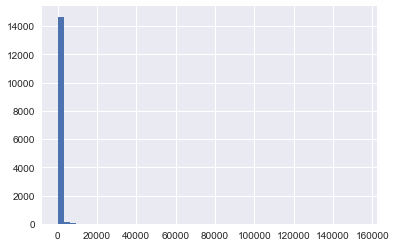

In [49]:
fig, ax = plt.subplots()
_ = ax.hist(clustered_read_counts, bins=50)

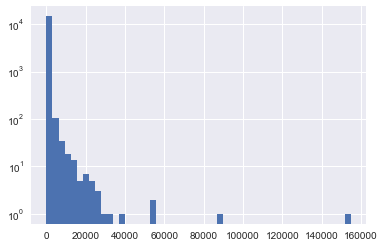

In [50]:
fig, ax = plt.subplots()
_ = ax.hist(clustered_read_counts, bins=50, log=True)

[(0, 1),
 None,
 (1.0, 154701.99999999991),

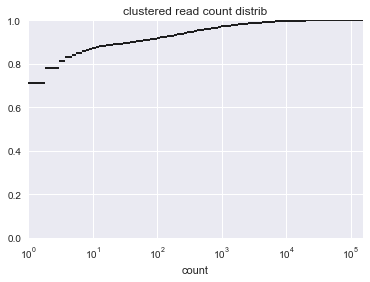

In [51]:
hist, bin_edges = np.histogram(clustered_read_counts, bins=np.logspace(0, np.log10(clustered_read_counts.max()), 100))
cdf = np.cumsum(hist) / hist.sum()
fig, ax = plt.subplots()
ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
ax.set(title='clustered read count distrib', xlabel='count', xlim=[bin_edges[0], bin_edges[-1]], ylim=[0, 1], xscale='log')

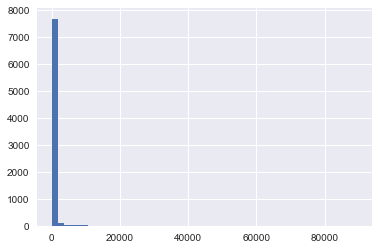

In [52]:
fig, ax = plt.subplots()
_ = ax.hist(aligned_clustered_read_counts, bins=50)

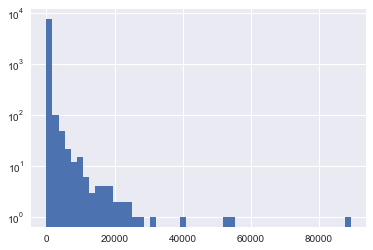

In [53]:
fig, ax = plt.subplots()
_ = ax.hist(aligned_clustered_read_counts, bins=50, log=True)

[(0, 1),
 None,
 (1.0, 154701.99999999991),

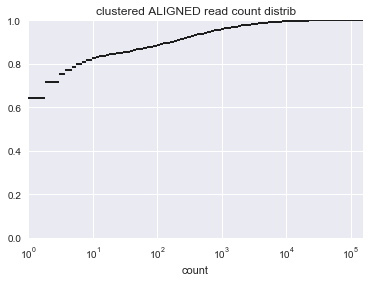

In [54]:
hist, bin_edges = np.histogram(aligned_clustered_read_counts, bins=np.logspace(0, np.log10(clustered_read_counts.max()), 100))
cdf = np.cumsum(hist) / hist.sum()
fig, ax = plt.subplots()
ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
ax.set(title='clustered ALIGNED read count distrib', xlabel='count', xlim=[bin_edges[0], bin_edges[-1]], ylim=[0, 1], xscale='log')

## Taxonomic distribution

In [55]:
names = ['pct_reads_clade', 'num_reads_clade', 'num_reads_taxon', 'rank', 'tax_id', 'tax_name']
converters = {'tax_name': lambda x: x.strip()}
td = pd.read_csv(kraken_report_path, sep='\t', header=None, names=names, converters=converters)

In [56]:
all_colors = sns.husl_palette(1000)
state = random.getstate()
random.seed(0)
random.shuffle(all_colors)
random.setstate(state)

def top_hits(df):
    return df.sort_values('pct_reads_clade', ascending=False, inplace=False)[:20]

def plot_distribution(df):
    fig, ax = plt.subplots()
    left = 0.2
    heights = df['pct_reads_clade'].values
    bottoms = [0] + list(np.cumsum(heights))[:-1]
    colors = all_colors[:len(heights)]
    labels = df['tax_name'].values
    for h, b, c, l in zip(heights, bottoms, colors, labels):
        if h > 0:
            ax.bar(left, h, width=0.4, bottom=b, color=c, label=l)
    ax.set(xlim=(0, 1))
    ax.legend()

Species

In [57]:
species = td[td['rank'] == 'S']
top_hits(species)

,pct_reads_clade,num_reads_clade,num_reads_taxon,rank,tax_id,tax_name
11,49.81,1459206,1459206,S,28116,Bacteroides ovatus
12,4.94,144700,144700,S,818,Bacteroides thetaiotaomicron
13,4.27,124995,124995,S,821,Bacteroides vulgatus
14,2.47,72277,72277,S,1796613,Bacteroides sp. I48
15,1.56,45653,45653,S,246787,Bacteroides cellulosilyticus
22,1.31,38427,38427,S,823,Parabacteroides distasonis
16,1.12,32889,32889,S,357276,Bacteroides dorei
17,0.81,23662,23662,S,817,Bacteroides fragilis
32,0.53,15634,15634,S,28118,Odoribacter splanchnicus
98,0.29,8537,8537,S,1834196,Lachnoclostridium sp. YL32


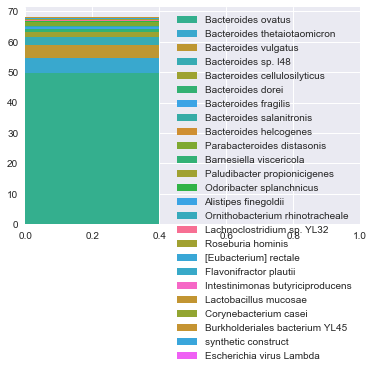

In [58]:
plot_distribution(species)

Genus

In [59]:
genuses = td[td['rank'] == 'G']
top_hits(genuses)

,pct_reads_clade,num_reads_clade,num_reads_taxon,rank,tax_id,tax_name
10,65.06,1906011,271,G,816,Bacteroides
21,1.31,38427,0,G,375288,Parabacteroides
31,0.53,15634,0,G,283168,Odoribacter
97,0.29,8541,0,G,1506553,Lachnoclostridium
100,0.26,7751,0,G,841,Roseburia
107,0.10,3057,0,G,946234,Flavonifractor
140,0.10,2827,0,G,1578,Lactobacillus
588,0.03,966,6,G,186765,Lambdavirus
34,0.02,658,0,G,239759,Alistipes
197,0.01,256,0,G,1716,Corynebacterium


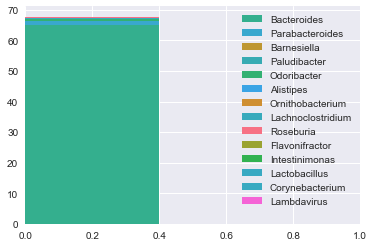

In [60]:
plot_distribution(genuses)

Family

In [61]:
families = td[td['rank'] == 'F']
top_hits(families)

,pct_reads_clade,num_reads_clade,num_reads_taxon,rank,tax_id,tax_name
9,65.06,1906011,0,F,815,Bacteroidaceae
20,1.33,38948,0,F,171551,Porphyromonadaceae
96,0.75,22080,0,F,186803,Lachnospiraceae
30,0.53,15634,0,F,1853231,Odoribacteraceae
139,0.10,2827,0,F,33958,Lactobacillaceae
587,0.03,966,0,F,10699,Siphoviridae
33,0.02,658,0,F,171550,Rikenellaceae
46,0.01,423,0,F,49546,Flavobacteriaceae
196,0.01,256,0,F,1653,Corynebacteriaceae
396,0.00,22,0,F,641,Vibrionaceae


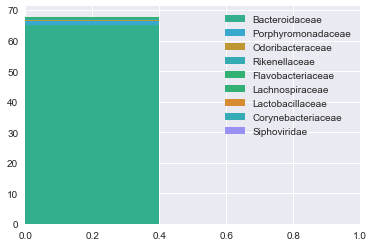

In [62]:
plot_distribution(families)

Order

In [63]:
orders = td[td['rank'] == 'O']
top_hits(orders)

,pct_reads_clade,num_reads_clade,num_reads_taxon,rank,tax_id,tax_name
8,66.94,1961272,0,O,171549,Bacteroidales
95,0.87,25405,0,O,186802,Clostridiales
138,0.10,2858,0,O,186826,Lactobacillales
300,0.09,2600,0,O,80840,Burkholderiales
586,0.03,969,0,O,28883,Caudovirales
45,0.01,423,0,O,200644,Flavobacteriales
195,0.01,260,0,O,85007,Corynebacteriales
88,0.00,13,0,O,191411,Chlorobiales
477,0.00,1,0,O,204441,Rhodospirillales
357,0.00,55,0,O,91347,Enterobacterales


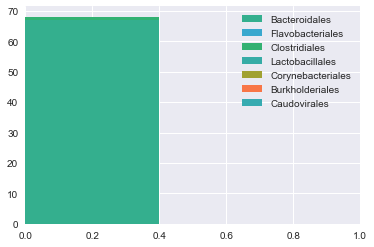

In [64]:
plot_distribution(orders)

Class

In [65]:
classes = td[td['rank'] == 'C']
top_hits(classes)

,pct_reads_clade,num_reads_clade,num_reads_taxon,rank,tax_id,tax_name
7,66.94,1961272,0,C,200643,Bacteroidia
94,0.87,25406,0,C,186801,Clostridia
137,0.10,2896,0,C,91061,Bacilli
299,0.09,2604,0,C,28216,Betaproteobacteria
194,0.01,266,0,C,1760,Actinobacteria
347,0.01,227,0,C,1236,Gammaproteobacteria
44,0.01,423,0,C,117743,Flavobacteriia
293,0.00,3,0,C,475962,Caldilineae
546,0.00,1,0,C,204429,Chlamydiia
540,0.00,1,0,C,203683,Planctomycetia


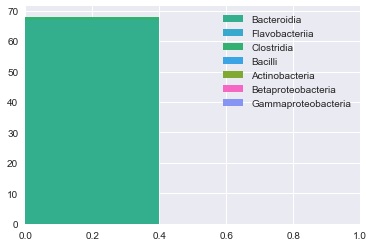

In [66]:
plot_distribution(classes)

Phylum

In [67]:
phyla = td[td['rank'] == 'P']
top_hits(phyla)

,pct_reads_clade,num_reads_clade,num_reads_taxon,rank,tax_id,tax_name
6,66.96,1961757,0,P,976,Bacteroidetes
93,0.97,28375,0,P,1239,Firmicutes
298,0.10,2907,0,P,1224,Proteobacteria
193,0.01,285,0,P,201174,Actinobacteria
86,0.00,13,0,P,1090,Chlorobi
256,0.00,10,0,P,544448,Tenericutes
262,0.00,3,0,P,1297,Deinococcus-Thermus
275,0.00,3,0,P,1117,Cyanobacteria
292,0.00,3,0,P,200795,Chloroflexi
523,0.00,13,0,P,203691,Spirochaetes


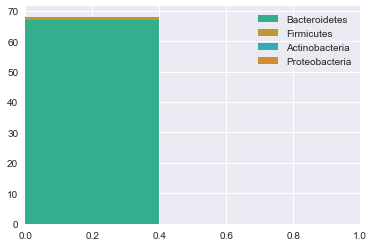

In [68]:
plot_distribution(phyla)